X_vectorized.shape: (1762, 51)
X_vectorized array length: 1762
X_transformed.shape: (1762, 52)
X_vectorized.shape: (1176, 51)
X_vectorized array length: 1176
X_transformed.shape: (1176, 52)
cv_results_ :  {'mean_fit_time': array([2.34629908, 4.35654993, 0.78881249, 2.86137276, 2.8351006 ,
       4.38663874, 0.70373316, 0.83798451, 2.46873636, 1.70673947,
       3.83276114, 2.90638056, 4.81792774, 0.74911685, 4.4386692 ,
       5.41572628, 4.19908676, 3.08448567, 1.25840387, 0.77773705,
       1.84478292, 4.93034644, 5.46439486, 1.80534616, 2.03442793,
       1.65422111, 4.91682534, 4.63688173, 0.83240261, 1.05075941,
       4.82618947, 1.78208003, 1.9721911 , 5.32123489, 0.74492674,
       3.05018029, 3.0897841 , 1.3845726 , 4.54797106, 5.01983585,
       3.44202571, 4.73457994, 1.56958976, 1.83872318, 2.88400435,
       1.81142454, 3.42053289, 5.05380697, 3.37215323, 4.98879299,
       4.79604678, 1.22605681, 2.89442878, 0.75898805, 2.1616631 ,
       2.89415631, 0.85424166, 1.9549846

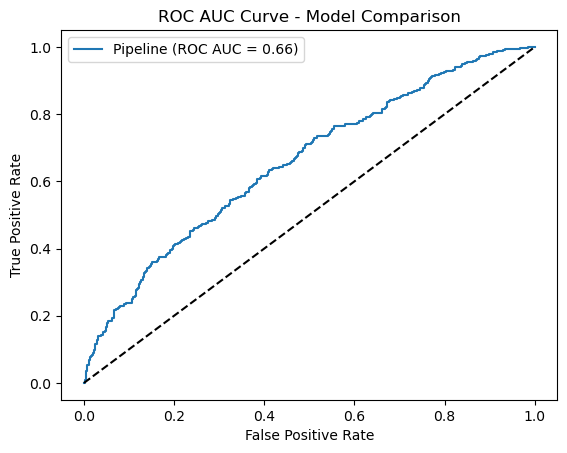

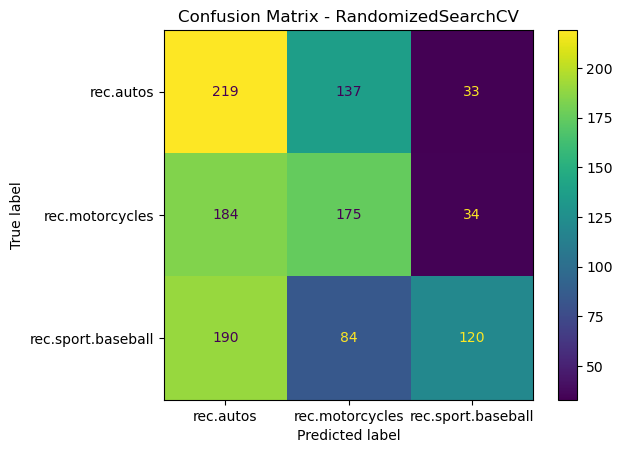


The tunning of RandomForestClassifier process took: 
	969.1519114971161 seconds 

Finished writing file


In [1]:
import time
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.discriminant_analysis import StandardScaler
from sklearn.model_selection import (
    RandomizedSearchCV,
    StratifiedKFold,
)
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    classification_report,
    confusion_matrix,
    f1_score,
    make_scorer,
    roc_auc_score,
    roc_curve,
)
from sklearn.feature_extraction.text import CountVectorizer
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE


start = time.time()


def getDataframeXyAndLabelEncoder(data):
    # Convert data into a dataframe
    df = pd.DataFrame(data)

    # Encode the "University" column into numerical values
    label_encoder = LabelEncoder()
    # df["University"] = label_encoder.fit_transform(df["University"])
    df["organization"] = label_encoder.fit_transform(df["organization"])

    # Create a separate dataframe for the "University" column
    # df_university = pd.DataFrame(df["University"])
    df_organization = pd.DataFrame(df["organization"])

    # Generate a new dataset by merging three columns
    # X = df["Course_Name"] + " " + df["Course_Description"] + " " + df["Skills"]
    X = df["subject"] + " " + df["text"]

    X = pd.DataFrame(X)
    # X = X.rename(columns={0: "Name_Description_Skills"})
    X = X.rename(columns={0: "Subject_Email"})

    # Vectorize the text data using CountVectorizer
    count_vect = CountVectorizer(max_features=51, ngram_range=(1, 2), lowercase=True)
    # X_vectorized = count_vect.fit_transform(X["Name_Description_Skills"])
    X_vectorized = count_vect.fit_transform(X["Subject_Email"])

    # Print the shape of the vectorized data
    print("X_vectorized.shape:", X_vectorized.shape)
    print("X_vectorized array length:", len(X_vectorized.toarray()))

    # Convert the vectorized data into a dataframe
    X_vectorized_array = X_vectorized.toarray()
    X_vectorized_df = pd.DataFrame(X_vectorized_array)

    # Rename columns of the dataframe created from CountVectorizer
    X_vectorized_df.columns = X_vectorized_df.columns.astype(str)

    # Add the "University" column back to the dataframe
    # X_vectorized_df.insert(0, "University", df_university, True)
    X_vectorized_df.insert(0, "organization", df_organization, True)

    X_transformed = X_vectorized_df

    # Print the shape of the transformed data
    print("X_transformed.shape:", X_transformed.shape)

    # Encode the target labels to numerical values
    label_encoder = LabelEncoder()
    # df["Difficulty_Level_Encoded"] = label_encoder.fit_transform(df["Difficulty_Level"])
    # y_encoded = df["Difficulty_Level_Encoded"]
    df["target"] = label_encoder.fit_transform(df["target"])
    y_encoded = df["target"]

    return X_transformed, y_encoded, label_encoder


# read the data from storage
data_from_train_dataset = pd.read_csv(
    "train_SCIKIT_DATA.csv", sep=";", encoding="latin-1"
)

# prepare data
X_train_transformed, y_train, label_encoder = getDataframeXyAndLabelEncoder(
    data_from_train_dataset
)

# read the data from storage
data_from_test_dataset = pd.read_csv(
    "test_SCIKIT_DATA.csv", sep=";", encoding="latin-1"
)

# prepare data
X_test_transformed, y_test, label_encoder = getDataframeXyAndLabelEncoder(
    data_from_test_dataset
)

# Define the parameter grid for RandomForestClassifier
param_grid = {
    # The number of trees in the forest
    "model__n_estimators": [120, 220, 420, 720],  # range of params for testing
    "model__criterion": ["gini", "log_loss"],  # range of params for testing
    # # The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.
    "model__max_depth": range(1, 20),  # range of params for testing
    # # Minimum number of samples required to split an internal node
    "model__min_samples_split": range(1, 20),  # range of params for testing
    # # Minimum number of samples required to be at a leaf node
    "model__min_samples_leaf": range(1, 20),  # range of params for testing
    # # Number of features to consider when looking for the best split
    "model__max_features": ["sqrt", "log2"],  # range of params for testing
    # # Number of jobs to run in parallel (-1 means using all processors)
    "model__n_jobs": [-1],
    # # disabled to do not crash the notebook
    # "model__verbose": [1],
    # # The “balanced” mode uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data as n_samples / (n_classes * np.bincount(y))
    "model__class_weight": ["balanced"],
    # # deixei o default The subtree with the largest cost complexity that is smaller than ccp_alpha will be chosen.
    "model__ccp_alpha": [0.0, 0.1, 0.2, 0.3],  # range of params for testing
}


clf = RandomForestClassifier()

# to avoid data leakage across folds, perform all the steps of pipeline in each fold
# Create a pipeline with SMOTE oversampling, scaling, and the classifier
pipe = Pipeline(
    steps=[
        ("smote", SMOTE(random_state=42)),
        ("standardscaler", StandardScaler()),
        ("model", clf),
    ]
)

scoring = {
    # The beta parameter determines the weight of recall in the combined score. beta < 1 lends more weight to precision, while beta > 1 favors recall
    # f_beta allows to choose a customized beta score, f1_score dont. If I try to pass beta parameter to f1_score, I get the error "f1_score() got an unexpected keyword argument "beta""
    # f1_score: The relative contribution of precision and recall to the F1 score are equal https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html
    # "f1": make_scorer(f_beta_score, average="weighted", beta=1),
    "f1": make_scorer(f1_score, average="weighted"),
}

# Perform cross-validation for each model using the same folds
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Otimized to f1 score only
# Perform grid search to find the best parameters
""" searchCV = GridSearchCV(
    clf,
    param_grid,
    scoring=scoring["f1"],
    refit="f1",
    cv=skf,
    error_score="raise",
    n_jobs=-1,
    verbose=1,
) """


# RandomizedSearchCV chosen instead of GridSearchCV because of resources cost (prossessing time)
# Perform RandomizedSearchCV to find the best parameters
searchCV = RandomizedSearchCV(
    pipe,
    param_grid,
    n_iter=512,
    scoring=scoring["f1"],
    refit="f1",
    cv=skf,
    error_score="raise",
    n_jobs=-1,
    random_state=42,
    # verbose=1,
)

# Create a pipeline with SMOTE oversampling, scaling, and the RandomizedSearchCV
pipe_SearchCV = Pipeline(
    steps=[
        ("smote", SMOTE(random_state=42)),
        ("standardscaler", StandardScaler()),
        ("model", searchCV),
    ]
)

pipe_SearchCV.fit(X_train_transformed, y_train)

# Retrieve the results of the RandomizedSearchCV
results = searchCV.cv_results_
print("cv_results_ : ", results)
print("Best Parameters:", searchCV.best_params_)
print("Best F1 Score:", searchCV.best_score_)

# Evaluate the model on the test set
y_pred = pipe_SearchCV.predict(X_test_transformed)
report = classification_report(y_test, y_pred)
print("Classification report: ", report)


def plotRocAucCurve():
    # Get the predicted probabilities for each class on the test set
    y_scores = pipe_SearchCV.predict_proba(X_test_transformed)
    # Calculate the ROC AUC score
    roc_auc = roc_auc_score(y_test, y_scores, multi_class="ovr")
    print("\t \t ROC AUC score: ", roc_auc, "\n")

    # Set plot title and labels

    fpr, tpr, _ = roc_curve(y_test, y_scores[:, 1], pos_label=1)

    plt.plot(
        fpr,
        tpr,
        label="{} (ROC AUC = {:.2f})".format(pipe_SearchCV.__class__.__name__, roc_auc),
    )

    plt.title("ROC AUC Curve - Model Comparison")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.plot([0, 1], [0, 1], "k--")
    # Add a legend
    plt.legend()
    # Show the plot
    plt.show()
    return roc_auc


roc_auc_result = plotRocAucCurve()


def plotConfusionMatrix(y_test, y_pred):
    # Calculate and store the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    # Plot the confusion matrix for each model
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm, display_labels=label_encoder.classes_
    )
    disp.plot()
    plt.title(f"Confusion Matrix - {searchCV.__class__.__name__}")
    plt.show()
    return cm


confusion_matrix_result = plotConfusionMatrix(y_test, y_pred)


end = time.time()

# # # # # # # # print("RESULTS GridSearchCV \n".join(map(str, results)))

file_path = "results_tunning_RandomForestClassifier.txt"

# Open the file in write mode
with open(file_path, "w") as file:
    # Write the contents of results array to the file
    file.write("best_params: \n")
    file.write("\t" + str(searchCV.best_params_))
    file.write("\n\n")
    file.write("best_score_: \n")
    file.write("\t" + str(searchCV.best_score_))
    file.write("\n\n")
    file.write("Classification report: \n")
    file.write(report)
    file.write("\n\n")
    file.write("ROC AUC score: \n")
    file.write("\t" + str(roc_auc_result))
    file.write("\n\n")
    file.write("Confusion matrix: \n")
    file.write("\t" + str(confusion_matrix_result[0]) + "\n")
    file.write("\t" + str(confusion_matrix_result[1]) + "\n")
    file.write("\t" + str(confusion_matrix_result[2]))
    file.write("\n\n")
    time_elapsed = str(end - start)
    message = (
        "\nThe tunning of RandomForestClassifier process took: \n"
        + "\t"
        + time_elapsed
        + " seconds \n"
    )
    file.write(message)
    file.write("\ncv_results: \n")
    file.write(str(searchCV.cv_results_))

print(
    "\nThe tunning of RandomForestClassifier process took: \n"
    + "\t"
    + time_elapsed
    + " seconds \n"
)
print("Finished writing file")